## ДЗ №3 Двухуровневый пайплайн
#### В этой домашке вам предстоит написать с нуля двустадийную рекомендательную систему.

#### Дата выдачи: 10.03.25

#### Мягкий дедлайн: 31.03.25 23:59 MSK

#### Жесткий дедлайн: 7.04.25 23:59 MSK

### Описание
Это творческое задание, в котором вам необходимо реализовать полный цикл построения рекомендательной системы: реализовать кандидат генераторов, придумать и собрать признаки, обучить итоговый ранкер и заинференсить модели на всех пользователей.

Вам предоставляется два набора данных: `train.csv` и `test.csv`

In [ ]:
# %pip install --upgrade pip -q

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
# скачиваем данные
# если из этой ячейки не получается, то вот ссылка на папку https://drive.google.com/drive/folders/1HT0Apm8Jft0VPLJtdBBUGu9s1M7vZcoJ?usp=drive_link

!pip3 install gdown

import gdown
# train
url = "https://drive.google.com/uc?id=1-CcS22-UpTJeNcFlA0dVLrEQn8jnI0d-"

output = 'train.csv'
gdown.download(url, output, quiet=True)

# test
url = "https://drive.google.com/uc?id=11iz3xDh0IIoEIBY0dyRSvByY3qfiT3BG"

output = 'test.csv'
gdown.download(url, output, quiet=True)

# user features
url = "https://drive.google.com/uc?id=1zl2jWMdUhc-IMakHlihQhJ5PGGZm9-_O"
output = 'users.csv'
gdown.download(url, output, quiet=True, fuzzy=True)

# item features
url = "https://drive.google.com/uc?id=1chCmpiCKJRjdqNftHc-t2ALl3qbAp2G8"
output = 'items.csv'
gdown.download(url, output, quiet=True)

'items.csv'

In [ ]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
users = pd.read_csv('users.csv')
items = pd.read_csv('items.csv')

In [ ]:
train.shape, test.shape, users.shape, items.shape

((4866956, 6), (608467, 6), (840197, 5), (15963, 14))

In [ ]:
train.head(2)

,user_id,item_id,last_watch_dt,total_dur,watched_pct,target
0,310745,13373,2021-03-13,4485,98.0,1
1,952323,15997,2021-03-13,7507,100.0,1


In [ ]:
test.head(2)

,user_id,item_id,last_watch_dt,total_dur,watched_pct,target
0,718866,6382,2021-08-13,10309,19.0,0
1,147119,13865,2021-08-13,1666,26.0,0


In [ ]:
users.head(2)

,user_id,age,income,sex,kids_flg
0,973171,age_25_34,income_60_90,М,1
1,962099,age_18_24,income_20_40,М,0


In [ ]:
items.head(2)

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords
0,10711,film,Поговори с ней,Hable con ella,2002.0,"драмы, зарубежные, детективы, мелодрамы",Испания,NaN,16.0,NaN,Педро Альмодовар,"Адольфо Фернандес, Ана Фернандес, Дарио Гранди...",Мелодрама легендарного Педро Альмодовара «Пого...,"Поговори, ней, 2002, Испания, друзья, любовь, ..."
1,2508,film,Голые перцы,Search Party,2014.0,"зарубежные, приключения, комедии",США,NaN,16.0,NaN,Скот Армстронг,"Адам Палли, Брайан Хаски, Дж.Б. Смув, Джейсон ...",Уморительная современная комедия на популярную...,"Голые, перцы, 2014, США, друзья, свадьбы, прео..."


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4866956 entries, 0 to 4866955
Data columns (total 6 columns):
 #   Column         Dtype  
---  ------         -----  
 0   user_id        int64  
 1   item_id        int64  
 2   last_watch_dt  object 
 3   total_dur      int64  
 4   watched_pct    float64
 5   target         int64  
dtypes: float64(1), int64(4), object(1)
memory usage: 222.8+ MB


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 608467 entries, 0 to 608466
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   user_id        608467 non-null  int64  
 1   item_id        608467 non-null  int64  
 2   last_watch_dt  608467 non-null  object 
 3   total_dur      608467 non-null  int64  
 4   watched_pct    608467 non-null  float64
 5   target         608467 non-null  int64  
dtypes: float64(1), int64(4), object(1)
memory usage: 27.9+ MB


In [ ]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 840197 entries, 0 to 840196
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user_id   840197 non-null  int64 
 1   age       826102 non-null  object
 2   income    825421 non-null  object
 3   sex       826366 non-null  object
 4   kids_flg  840197 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 32.1+ MB


In [ ]:
items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15963 entries, 0 to 15962
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   item_id       15963 non-null  int64  
 1   content_type  15963 non-null  object 
 2   title         15963 non-null  object 
 3   title_orig    11218 non-null  object 
 4   release_year  15865 non-null  float64
 5   genres        15963 non-null  object 
 6   countries     15926 non-null  object 
 7   for_kids      566 non-null    float64
 8   age_rating    15961 non-null  float64
 9   studios       1065 non-null   object 
 10  directors     14454 non-null  object 
 11  actors        13344 non-null  object 
 12  description   15961 non-null  object 
 13  keywords      15540 non-null  object 
dtypes: float64(3), int64(1), object(10)
memory usage: 1.7+ MB




### 1 Этап. Модели первого уровня. (max 3 балла)
В этом этапе вам необходимо разделить `train` датасет на 2 части: для обучения моделей первого уровня и для их валидации. Единственное условие для разбиения – разбивать нужно по времени. Данные для обучение будем называть `train_stage_1`, данные для валидации `valid_stage_1`. Объемы этих датасетов вы определяет самостоятельно.

Для начала нам нужно отобрать кандидатов при помощи легких моделей. Необходимо реализовать 3 типа моделей:
1. Любая эвристическая(алгоритмичная) модель на ваш выбор **(0.5 балл)**
2. Любая матричная факторизация на ваш выбор **(1 балл)**
3. Любая нейросетевая модель на ваш выбор **(1 балла)**

Не забудьте использовать скор каждой модели, как признак!



Каждая модель должна уметь:
1) для пары user_item предсказывать скор релевантности (масштаб скора не важен), важно обработать случаи, когда модель не можеn проскорить пользователя или айтем, вместо этого вернуть какое-то дефолтное значение
2) для всех пользователей вернуть top-k самых релевантных айтемов (тут вам скоры не нужны)


Дополнительно можно провести анализ кандидат генератов, измерить насколько различные айтемы они рекомендуют, например с помощью таких метрик как: [Ranked based overlap](https://github.com/changyaochen/rbo) или различные вариации [Diversity](https://github.com/MaurizioFD/RecSys2019_DeepLearning_Evaluation/blob/master/Base/Evaluation/metrics.py#L289). **(1 балл)**

In [ ]:
train['last_watch_dt'] = pd.to_datetime(train['last_watch_dt'])
split_date = train['last_watch_dt'].quantile(0.7) + pd.Timedelta(days=1)
train_stage_1 = train[train['last_watch_dt'] < split_date]
valid_stage_1 = train[train['last_watch_dt'] >= split_date]

In [ ]:
train_stage_1.tail()

,user_id,item_id,last_watch_dt,total_dur,watched_pct,target
3410706,626706,5266,2021-07-15,12168,100.0,1
3410707,45016,16447,2021-07-15,7949,99.0,1
3410708,121617,8727,2021-07-15,11,0.0,0
3410709,952062,6738,2021-07-15,17,0.0,0
3410710,977188,4774,2021-07-15,7245,92.0,1


In [ ]:
valid_stage_1.head()

,user_id,item_id,last_watch_dt,total_dur,watched_pct,target
3410711,208171,3182,2021-07-16,28798,100.0,1
3410712,192280,11348,2021-07-16,7804,100.0,1
3410713,808491,10240,2021-07-16,161,3.0,0
3410714,702862,144,2021-07-16,1578,21.0,0
3410715,880491,16228,2021-07-16,67937,36.0,0


In [ ]:
train_stage_1.shape, valid_stage_1.shape

((3410711, 6), (1456245, 6))

In [ ]:
class MyHeuristicModel:
    def fit(self, df):
        self.popular_items = df[df['target'] == 1]['item_id'].value_counts().index.tolist()

    def recommend(self, user_ids, k=10):
        return {user_id: self.popular_items[:k] for user_id in user_ids}

    def predict_score(self, user_id, item_id):
        return 1 if item_id in self.popular_items[:100] else 0

In [ ]:
top_pop = MyHeuristicModel()
top_pop.fit(train_stage_1)

In [ ]:
%pip install implicit -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 75.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import scipy.sparse as sparse
from implicit.als import AlternatingLeastSquares

In [ ]:
class MyMatrixFactorization:
    def __init__(self, factors=50):
        self.model = AlternatingLeastSquares(factors=factors, iterations=10)

    def fit(self, df):
        self.user_ids = df['user_id'].unique()
        self.item_ids = df['item_id'].unique()
        self.user_map = {u: i for i, u in enumerate(self.user_ids)}
        self.item_map = {i: j for j, i in enumerate(self.item_ids)}
        self.user_inv = {i: u for u, i in self.user_map.items()}
        self.item_inv = {j: i for i, j in self.item_map.items()}

        rows = df['user_id'].map(self.user_map)
        cols = df['item_id'].map(self.item_map)
        data = df['target']

        self.matrix = sparse.csr_matrix((data, (rows, cols)))
        self.model.fit(self.matrix)

    def recommend(self, user_ids, k=10):
        recs = {}
        for user_id in user_ids:
            if user_id in self.user_map:
                rec = self.model.recommend(self.user_map[user_id], self.matrix, N=k)
                recs[user_id] = [self.item_inv[i] for i, _ in rec]
            else:
                recs[user_id] = []
        return recs

    def predict_score(self, user_id, item_id):
        if user_id not in self.user_map or item_id not in self.item_map:
            return 0
        u, i = self.user_map[user_id], self.item_map[item_id]
        return self.model.user_factors[u] @ self.model.item_factors[i]

In [ ]:
als = MyMatrixFactorization()
als.fit(train_stage_1)

/usr/local/lib/python3.10/dist-packages/implicit/cpu/als.py:95: RuntimeWarning: Intel MKL BLAS is configured to use 2 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'MKL_NUM_THREADS=1' or by callng 'threadpoolctl.threadpool_limits(1, "blas")'. Having MKL use a threadpool can lead to severe performance issues
  check_blas_config()
/usr/local/lib/python3.10/dist-packages/implicit/cpu/als.py:95: RuntimeWarning: OpenBLAS is configured to use 4 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()


  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
%pip install recbole==1.1.1 -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 9.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bayesian-optimization 2.0.3 requires colorama<0.5.0,>=0.4.6, but you have colorama 0.4.4 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import recbole
print(recbole.__version__)

1.1.1


In [ ]:
train_stage_1.head(2)

,user_id,item_id,last_watch_dt,total_dur,watched_pct,target
0,310745,13373,2021-03-13,4485,98.0,1
1,952323,15997,2021-03-13,7507,100.0,1


In [ ]:
import os
os.makedirs('data/gru4rec/train_stage_1', exist_ok=True)
df_inter = train_stage_1[['user_id', 'item_id', 'last_watch_dt']].copy()
df_inter['timestamp'] = pd.to_datetime(df_inter['last_watch_dt']).astype(int) // 10**9
df_inter = df_inter[['user_id', 'item_id', 'timestamp']]
df_inter.columns = ['user_id:token', 'item_id:token', 'timestamp:float']

df_inter.to_csv('data/gru4rec/train_stage_1/train_stage_1.inter', sep='\t', index=False)

In [ ]:
%pip uninstall -y tensorflow keras

Found existing installation: tensorflow 2.17.1
Uninstalling tensorflow-2.17.1:
  Successfully uninstalled tensorflow-2.17.1
Found existing installation: keras 3.5.0
Uninstalling keras-3.5.0:
  Successfully uninstalled keras-3.5.0
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import gc
import torch

gc.collect()

if torch.cuda.is_available():
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()

Далее пойдут оптимальные параметры для gru4rec, чтобы загрузить видеокарту на 90% и 8gb из 16-ти. Я их подбирал очень долго =)

In [ ]:
from recbole.config import Config
from recbole.data import create_dataset, data_preparation
from recbole.model.sequential_recommender import GRU4Rec
from recbole.trainer import Trainer
from recbole.utils import init_seed, init_logger
import os

cpu = os.cpu_count()

config = Config(
    model='GRU4Rec',
    dataset='train_stage_1',
    config_dict={

        'data_path': 'data/gru4rec',
        'field_separator': '\t',
        'USER_ID_FIELD': 'user_id',
        'ITEM_ID_FIELD': 'item_id',
        'TIME_FIELD': 'timestamp',
        'load_col': {'inter': ['user_id', 'item_id', 'timestamp']},

        'MODEL_INPUT_TYPE': 'sequence',
        'MAX_ITEM_LIST_LENGTH': 50,

        'eval_args': {
            'split': {'RS': [0.8, 0.1, 0.1]},
            'order': 'TO',
            'mode': 'full',
            'group_by': 'user',
            'order_by': 'timestamp'
        },
        'metrics': ['Recall', 'NDCG'],
        'topk': [10],
        'valid_metric': 'Recall@10',
        'eval_batch_size': 8192,

        'train_epochs': 5,
        'train_batch_size': 4096,
        'loss_type': 'CE',
        'train_neg_sample_args': None,

        'device': 'cuda' if torch.cuda.is_available() else 'cpu',
        'train_num_workers': max(1, cpu // 2),
        'eval_num_workers': 1,
        'pin_memory': True,
        'prefetch': 4,

        'eval_step': 1,
        'stopping_step': 2,

        'show_progress': False
    }
)

In [ ]:
init_seed(config['seed'], config['reproducibility'])
init_logger(config)

dataset = create_dataset(config)
train_data, valid_data, test_data = data_preparation(config, dataset)

/usr/local/lib/python3.10/dist-packages/recbole/data/dataset/dataset.py:638: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  feat[field].fillna(value=0, inplace=True)
/usr/local/lib/python3.10/dist-packages/recbole/data/dataset/dataset.py:640: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a c

Старый recbol 1.1.1 ругается на np.float, заменим

In [ ]:
np.float = float

In [ ]:
%%time

model = GRU4Rec(config, train_data.dataset).to(config['device'])
trainer = Trainer(config, model)

best_valid_score, best_valid_result = trainer.fit(
    train_data, valid_data, verbose=False, show_progress=False
)

/usr/local/lib/python3.10/dist-packages/recbole/trainer/trainer.py:236: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler(enabled=self.enable_scaler)


CPU times: user 20min 59s, sys: 21.6 s, total: 21min 21s
Wall time: 17min 23s


In [ ]:
class ALSWrapper:
    def __init__(self, model, user_id_map, item_id_map):
        self.model = model
        self.user_id_map = user_id_map
        self.item_id_map = item_id_map
        self.user_factors = model.user_factors
        self.item_factors = model.item_factors

    def predict_score(self, user_id, item_id):
        uid = self.user_id_map.get(user_id)
        iid = self.item_id_map.get(item_id)
        if uid is None or iid is None:
            return 0.0
        return float(np.dot(self.user_factors[uid], self.item_factors[iid]))

    def get_top_k(self, user_id, k=10):
        uid = self.user_id_map.get(user_id)
        if uid is None:
            return []
        user_vector = self.user_factors[uid]
        scores = self.item_factors @ user_vector
        top_k = np.argsort(-scores)[:k]
        inv_item_map = {v: k for k, v in self.item_id_map.items()}
        return [inv_item_map[i] for i in top_k]

class GRU4RecWrapper:
    def __init__(self, model, dataset, config):
        self.model = model
        self.dataset = dataset
        self.config = config
        self.item_num = dataset.item_num

    def predict_score(self, user_history, item_id):
        if not user_history:
            return 0.0
        user_history = user_history[-self.config['MAX_ITEM_LIST_LENGTH']:]
        input_data = torch.tensor([user_history], dtype=torch.long).to(self.config['device'])
        length_tensor = torch.tensor([len(user_history)], dtype=torch.long).to(self.config['device'])
        output = self.model(input_data, length_tensor)
        return float(output[0][item_id]) if 0 <= item_id < self.item_num else 0.0

    def get_top_k(self, user_history, k=10):
        if not user_history:
            return []
        user_history = user_history[-self.config['MAX_ITEM_LIST_LENGTH']:]
        input_data = torch.tensor([user_history], dtype=torch.long).to(self.config['device'])
        length_tensor = torch.tensor([len(user_history)], dtype=torch.long).to(self.config['device'])
        output = self.model(input_data, length_tensor)
        top_k = torch.topk(output[0], k=k).indices.cpu().numpy()
        return top_k.tolist()

class TopKHeuristic:
    def __init__(self, top_items):
        self.top_items = top_items

    def predict_score(self, user_id, item_id):
        return 1.0 if item_id in self.top_items else 0.0

    def get_top_k(self, user_id, k=10):
        return self.top_items[:k]

In [ ]:
top_wrapper = TopKHeuristic(top_pop.popular_items)
als_wrapper = ALSWrapper(als.model, als.user_map, als.item_map)

In [ ]:
model

GRU4Rec(
  (item_embedding): Embedding(14777, 64, padding_idx=0)
  (emb_dropout): Dropout(p=0.3, inplace=False)
  (gru_layers): GRU(64, 128, bias=False, batch_first=True)
  (dense): Linear(in_features=128, out_features=64, bias=True)
  (loss_fct): CrossEntropyLoss()
)

In [ ]:
dataset

train_stage_1
The number of users: 672564
Average actions of users: 6.606862271981469
The number of items: 14777
Average actions of items: 188.6036644165863
The number of inters: 2738148
The sparsity of the dataset: 99.97244902149822%
Remain Fields: ['user_id', 'item_id', 'timestamp', 'item_id_list', 'timestamp_list', 'item_length']

In [ ]:
config


General Hyper Parameters:
gpu_id = 0
use_gpu = True
seed = 2020
state = INFO
reproducibility = True
data_path = data/gru4rec/train_stage_1
checkpoint_dir = saved
show_progress = False
save_dataset = False
dataset_save_path = None
save_dataloaders = False
dataloaders_save_path = None
log_wandb = False

Training Hyper Parameters:
epochs = 300
train_batch_size = 4096
learner = adam
learning_rate = 0.001
train_neg_sample_args = {'distribution': 'none', 'sample_num': 'none', 'alpha': 'none', 'dynamic': False, 'candidate_num': 0}
eval_step = 1
stopping_step = 2
clip_grad_norm = None
weight_decay = 0.0
loss_decimal_place = 4

Evaluation Hyper Parameters:
eval_args = {'split': {'RS': [0.8, 0.1, 0.1]}, 'order': 'TO', 'mode': 'full', 'group_by': 'user', 'order_by': 'timestamp'}
repeatable = True
metrics = ['Recall', 'NDCG']
topk = [10]
valid_metric = Recall@10
valid_metric_bigger = True
eval_batch_size = 8192
metric_decimal_place = 4

Dataset Hyper Parameters:
field_separator = 	
seq_separator 

In [ ]:
def generate_candidates(model, users, k, model_name, get_history=None):
    data = []
    for user_id in users:
        history = get_history(user_id) if get_history else None
        try:
            recs = model.get_top_k(user_id if history is None else history, k)
        except:
            recs = []
        for item_id in recs:
            try:
                score = model.predict_score(user_id if history is None else history, item_id)
            except:
                score = 0.0
            data.append({
                'user_id': user_id,
                'item_id': item_id,
                'score': score,
                'model': model_name
            })
    return pd.DataFrame(data)

In [ ]:
%%time

candidates_top = generate_candidates(top_wrapper, valid_stage_1['user_id'].unique(), 10, 'topk')
candidates_als = generate_candidates(als_wrapper, valid_stage_1['user_id'].unique(), 10, 'als')

CPU times: user 10min 2s, sys: 1.26 s, total: 10min 3s
Wall time: 5min 10s


In [ ]:
def generate_candidates_userwise(model, user2history, user_ids, k=10, model_name='gru'):
    device = model.config['device']
    item_num = model.item_num
    max_len = model.config['MAX_ITEM_LIST_LENGTH']
    data = []

    total = len(user_ids)
    processed = 0
    skipped_empty = 0
    skipped_nan = 0
    failed = 0

    for idx, uid in enumerate(user_ids):
        hist = user2history.get(uid, [])
        hist = [item for item in hist if isinstance(item, int) and 0 <= item < item_num]

        if not hist:
            skipped_empty += 1
            continue

        hist = hist[-max_len:]
        input_tensor = torch.tensor([hist], dtype=torch.long).to(device)
        length_tensor = torch.tensor([len(hist)], dtype=torch.long).to(device)

        try:
            with torch.no_grad():
                output = model.model(input_tensor, length_tensor)
                if output.isnan().any() or output.isinf().any():
                    skipped_nan += 1
                    continue

                topk_scores, topk_indices = torch.topk(output, k=k, dim=1)

            for item_id, score in zip(topk_indices[0].tolist(), topk_scores[0].tolist()):
                if 0 <= item_id < item_num:
                    data.append({
                        'user_id': uid,
                        'item_id': item_id,
                        'score': score,
                        'model': model_name
                    })

            processed += 1

        except Exception as e:
            print(f"Ошибка у user_id={uid}: {e}")
            failed += 1
            continue

        if (idx + 1) % 50000 == 0:
            print(f"Обработано {idx + 1} из {total} пользователей...")

    print(f"\nЗавершено. Всего: {total}")
    print(f"Обработано: {processed}")
    print(f"Пропущено (пустые истории): {skipped_empty}")
    print(f"Пропущено (NaN/Inf): {skipped_nan}")
    print(f"Ошибки: {failed}")

    return pd.DataFrame(data)

In [ ]:
def get_internal_user_history_dict(dataset):
    user_col = dataset.uid_field
    item_col = dataset.iid_field
    time_col = dataset.time_field

    df = pd.DataFrame({
        user_col: dataset.inter_feat[user_col].numpy(),
        item_col: dataset.inter_feat[item_col].numpy(),
        time_col: dataset.inter_feat[time_col].numpy()
    })

    df = df.sort_values(time_col)

    user_hist = {}
    for uid, group in df.groupby(user_col):
        user_hist[uid] = group[item_col].tolist()

    return user_hist

internal_user_history_dict = get_internal_user_history_dict(dataset)

In [ ]:
len(internal_user_history_dict)

414440

In [ ]:
model.eval()

GRU4Rec(
  (item_embedding): Embedding(14777, 64, padding_idx=0)
  (emb_dropout): Dropout(p=0.3, inplace=False)
  (gru_layers): GRU(64, 128, bias=False, batch_first=True)
  (dense): Linear(in_features=128, out_features=64, bias=True)
  (loss_fct): CrossEntropyLoss()
)

In [ ]:
gru_wrapper = GRU4RecWrapper(model, dataset, config)

In [ ]:
gru_wrapper

In [ ]:
valid_stage_1.shape

(1456245, 6)

In [ ]:
valid_stage_1['user_id'].unique().shape

(382800,)

In [ ]:
candidates_top.shape, candidates_als.shape

((3828000, 4), (1749420, 4))

In [ ]:
%%time

candidates_gru = generate_candidates_userwise(
    model=gru_wrapper,
    user2history=internal_user_history_dict,
    user_ids=list(internal_user_history_dict.keys()),
    k=10,
    model_name='gru'
)

Обработано 50000 из 414440 пользователей...
Обработано 100000 из 414440 пользователей...
Обработано 150000 из 414440 пользователей...
Обработано 200000 из 414440 пользователей...
Обработано 250000 из 414440 пользователей...
Обработано 300000 из 414440 пользователей...
Обработано 350000 из 414440 пользователей...
Обработано 400000 из 414440 пользователей...

Завершено. Всего: 414440
Обработано: 414440
Пропущено (пустые истории): 0
Пропущено (NaN/Inf): 0
Ошибки: 0
CPU times: user 4min 21s, sys: 1.81 s, total: 4min 23s
Wall time: 4min 23s


In [ ]:
candidates_gru.shape

(4144400, 4)

In [ ]:
candidates_gru.head()

,user_id,item_id,score,model
0,2,30,4.512095,gru
1,2,13,2.663654,gru
2,2,57,2.445568,gru
3,2,20,2.257750,gru
4,2,10,2.162546,gru


In [ ]:
candidates_top.head()

,user_id,item_id,score,model
0,208171,15297,1.0,topk
1,208171,10440,1.0,topk
2,208171,13865,1.0,topk
3,208171,9728,1.0,topk
4,208171,3734,1.0,topk


In [ ]:
candidates_top.shape, candidates_top.score.sum()

((3828000, 4), 3828000.0)

In [ ]:
candidates_als.head()

,user_id,item_id,score,model
0,208171,10440,0.149779,als
1,208171,12743,0.014232,als
2,208171,11310,0.010526,als
3,208171,10761,0.010125,als
4,208171,7582,0.009448,als


In [ ]:
candidates_gru.shape, candidates_top.shape, candidates_als.shape

((4144400, 4), (3828000, 4), (1749420, 4))

In [ ]:
def merge_model_outputs_for_l2(candidates_top, candidates_als, candidates_gru):
    top_pivot = candidates_top.rename(columns={'score': 'score_topk'}).drop(columns='model')
    als_pivot = candidates_als.rename(columns={'score': 'score_als'}).drop(columns='model')
    gru_pivot = candidates_gru.rename(columns={'score': 'score_gru'}).drop(columns='model')

    merged = pd.merge(top_pivot, als_pivot, on=['user_id', 'item_id'], how='outer')
    merged = pd.merge(merged, gru_pivot, on=['user_id', 'item_id'], how='outer')

    merged['score_topk'] = merged['score_topk'].fillna(0.0)
    merged['score_als'] = merged['score_als'].fillna(0.0)
    merged['score_gru'] = merged['score_gru'].fillna(0.0)

    return merged

In [ ]:
df_l2 = merge_model_outputs_for_l2(candidates_top, candidates_als, candidates_gru)

In [ ]:
df_l2.shape

(9431718, 5)

In [ ]:
df_l2.head()

,user_id,item_id,score_topk,score_als,score_gru
0,0,142,1.0,0.0,0.0
1,0,3734,1.0,0.0,0.0
2,0,4151,1.0,0.0,0.0
3,0,6809,1.0,0.0,0.0
4,0,8636,1.0,0.0,0.0


In [ ]:
valid_stage_1.head()

,user_id,item_id,last_watch_dt,total_dur,watched_pct,target
3410711,208171,3182,2021-07-16,28798,100.0,1
3410712,192280,11348,2021-07-16,7804,100.0,1
3410713,808491,10240,2021-07-16,161,3.0,0
3410714,702862,144,2021-07-16,1578,21.0,0
3410715,880491,16228,2021-07-16,67937,36.0,0


In [ ]:
valid_stage_1.shape

(1456245, 6)

In [ ]:
df_l2_train = valid_stage_1[['user_id', 'item_id', 'target']].merge(df_l2, on=['user_id', 'item_id'], how='left')

In [ ]:
df_l2_train.shape, valid_stage_1.shape

((1456245, 6), (1456245, 6))

In [ ]:
%pip install rbo -q

Note: you may need to restart the kernel to use updated packages.


In [ ]:
from rbo import RankingSimilarity

def get_rbo(model1, model2, user_ids, k=10):
    scores = []
    for uid in user_ids[:10000]:
        try:
            rec1 = model1.get_top_k(uid, k)
            rec2 = model2.get_top_k(uid, k)
            if rec1 and rec2:
                rbo_score = RankingSimilarity(rec1, rec2).rbo()
                scores.append(rbo_score)
        except Exception as e:
            print(f"Ошибка у user {uid}: {e}")
    return np.mean(scores)

Не получилось посчитать RBO с GRU4Rec, так как для пользователей валидации не оказалось историй (или я запутался).

In [ ]:
user_ids = valid_stage_1['user_id'].unique()

rbo_top_als = get_rbo(top_wrapper, als_wrapper, user_ids, k=10)
print(f"RBO между TopK и ALS: {rbo_top_als:.4f}")

RBO между TopK и ALS: 0.1835


Пересечения между рекомендациями двух моделей довольно небольшие, они предлагают разные кандидаты. Это хорошо для второго уровня (L2)

In [ ]:
def personalization(recommendations):
    import numpy as np
    from sklearn.metrics.pairwise import cosine_similarity

    item_sets = [set(rec) for rec in recommendations.values() if rec]
    overlap = 0
    total = 0
    for i in range(len(item_sets)):
        for j in range(i + 1, len(item_sets)):
            union = item_sets[i] | item_sets[j]
            if not union:
                continue
            overlap += len(item_sets[i] & item_sets[j]) / len(union)
            total += 1
    return round(1 - (overlap / total), 4) if total > 0 else None

from collections import defaultdict

def get_user2items(model, user_ids, k=10):
    user2items = defaultdict(list)
    for uid in user_ids[:1000]:
        user2items[uid] = model.get_top_k(uid, k)
    return user2items

top_items = get_user2items(top_wrapper, valid_stage_1['user_id'].unique())
als_items = get_user2items(als_wrapper, valid_stage_1['user_id'].unique())

print('Personalization TopK:', personalization(top_items))
print('Personalization ALS:', personalization(als_items))

Personalization TopK: 0.0
Personalization ALS: 0.9352


TopPopular рекомендует одни и те же айтемы всем пользователям → нулевая персонализация.
ALS выдает разнообразные персональные рекомендации, почти не повторяющиеся между пользователями, отлично!


### 2 Этап. Генерация и сборка признаков. (max 2 балла)
Необходимо собрать минимум 10 осмысленных (`np.radndom.rand()` не подойдет) признаков, при этом:
1. 2 должны относиться только к сущности "пользователь" (например средний % просмотра фильмов у этой возрастной категории)
2. 2 должны относиться только к сущности "айтем" (например средний средний % просмотра данного фильма)
3. 6 признаков, которые показывают связь пользователя и айтема (например средний % просмотра фильмов с данным актером (айтем) у пользователей с таким же полом (пользователь)).

### ВАЖНО!  

1. **В датасете есть колонка `watched_prct`. Ее можно использовать для генерации признаков (например сколько пользователь в среднем смотрит фильмы), но нельзя подавать в модель, как отдельную фичу, потому что она напрямую связана с target.**
2. **Все признаки должны быть собраны без дата лика, то есть если пользователь посмотрел фильм 10 августа, то признаки мы можем считать только на данных до 9 августа включительно.**


### Разбалловка
Обучение ранкера будет проходить на `valid_stage_1`, как  раз на которой мы валидировали модели, а тестировать на `test`. Поэтому есть 2 варианта сборки признаков, **реализовать нужно только 1 из них:**
1. Для обучения собираем признаки на первый день `valid_stage_1`, а для теста на первый день `test`. Например, если `valid_stage_1` начинается 5 сентября, то все признаки мы можем собирать только по 4 сентября включительно. **(1 балл)**
2. Признаки будем собирать честно на каждый день, то есть на 5 сентября собираем с начала до 4, на 6 сентября с начала до 5 и т.д. **(2 балла)**

Сделаем вариант номер 2, конечно же - честные фичи по срезам.

In [ ]:
valid_stage_1.head(3)

,user_id,item_id,last_watch_dt,total_dur,watched_pct,target
3410711,208171,3182,2021-07-16,28798,100.0,1
3410712,192280,11348,2021-07-16,7804,100.0,1
3410713,808491,10240,2021-07-16,161,3.0,0


In [ ]:
test.head(3)

,user_id,item_id,last_watch_dt,total_dur,watched_pct,target
0,718866,6382,2021-08-13,10309,19.0,0
1,147119,13865,2021-08-13,1666,26.0,0
2,1079425,4141,2021-08-13,774,10.0,0


In [ ]:
users.head(3)

,user_id,age,income,sex,kids_flg
0,973171,age_25_34,income_60_90,М,1
1,962099,age_18_24,income_20_40,М,0
2,1047345,age_45_54,income_40_60,Ж,0


In [ ]:
items.head(3)

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords
0,10711,film,Поговори с ней,Hable con ella,2002.0,"драмы, зарубежные, детективы, мелодрамы",Испания,NaN,16.0,NaN,Педро Альмодовар,"Адольфо Фернандес, Ана Фернандес, Дарио Гранди...",Мелодрама легендарного Педро Альмодовара «Пого...,"Поговори, ней, 2002, Испания, друзья, любовь, ..."
1,2508,film,Голые перцы,Search Party,2014.0,"зарубежные, приключения, комедии",США,NaN,16.0,NaN,Скот Армстронг,"Адам Палли, Брайан Хаски, Дж.Б. Смув, Джейсон ...",Уморительная современная комедия на популярную...,"Голые, перцы, 2014, США, друзья, свадьбы, прео..."
2,10716,film,Тактическая сила,Tactical Force,2011.0,"криминал, зарубежные, триллеры, боевики, комедии",Канада,NaN,16.0,NaN,Адам П. Калтраро,"Адриан Холмс, Даррен Шалави, Джерри Вассерман,...",Профессиональный рестлер Стив Остин («Все или ...,"Тактическая, сила, 2011, Канада, бандиты, ганг..."


In [ ]:
valid_stage_1.shape, train_stage_1.shape

((1456245, 6), (3410711, 6))

In [ ]:
df_l2_train.shape

(1456245, 6)

In [ ]:
df_l2_train.head()

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,user_id,item_id,target,score_topk,score_als,score_gru
0,208171,3182,1,0.0,0.007176,0.0
1,192280,11348,1,NaN,NaN,NaN
2,808491,10240,0,NaN,NaN,NaN
3,702862,144,0,NaN,NaN,NaN
4,880491,16228,0,NaN,NaN,NaN


In [ ]:
interactions = pd.concat([train_stage_1, valid_stage_1], ignore_index=True)
interactions['last_watch_dt'] = pd.to_datetime(interactions['last_watch_dt'])

In [ ]:
test.head()

,user_id,item_id,last_watch_dt,total_dur,watched_pct,target
0,718866,6382,2021-08-13,10309,19.0,0
1,147119,13865,2021-08-13,1666,26.0,0
2,1079425,4141,2021-08-13,774,10.0,0
3,810008,15297,2021-08-13,3,0.0,0
4,1068123,10440,2021-08-13,492,0.0,0


In [ ]:
test.shape

(608467, 6)

In [ ]:
df_l2_test = test[['user_id', 'item_id', 'target']].merge(df_l2, on=['user_id', 'item_id'], how='left')
df_l2_test.head()

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,user_id,item_id,target,score_topk,score_als,score_gru
0,718866,6382,0,NaN,NaN,NaN
1,147119,13865,0,NaN,NaN,NaN
2,1079425,4141,0,NaN,NaN,NaN
3,810008,15297,0,NaN,NaN,NaN
4,1068123,10440,0,NaN,NaN,NaN


In [ ]:
df_l2_test.target.sum()

212645

In [ ]:
df_l2_test.shape

(608467, 6)

In [ ]:
df_l2_test.score_topk.isna().sum()

570824

In [ ]:
df_l2_test.score_topk.sum()

34769.0

In [ ]:
df_l2_test.score_als.isna().sum()

570824

In [ ]:
df_l2_test.score_gru.isna().sum()

570824

In [ ]:
df_l2_train_full = valid_stage_1.merge(df_l2, on=['user_id', 'item_id'], how='left')

In [ ]:
df_l2_train.head(2)

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,user_id,item_id,target,score_topk,score_als,score_gru
0,208171,3182,1,0.0,0.007176,0.0
1,192280,11348,1,NaN,NaN,NaN


In [ ]:
df_l2_train_full.head(2)

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,user_id,item_id,last_watch_dt,total_dur,watched_pct,target,score_topk,score_als,score_gru
0,208171,3182,2021-07-16,28798,100.0,1,0.0,0.007176,0.0
1,192280,11348,2021-07-16,7804,100.0,1,NaN,NaN,NaN


In [ ]:
df_l2_train.shape, df_l2_train_full.shape

((1456245, 6), (1456245, 9))

In [ ]:
df_l2_test_full = test.merge(df_l2, on=['user_id', 'item_id'], how='left')
df_l2_test_full.shape, df_l2_test.shape

((608467, 9), (608467, 6))

In [ ]:
df_l2_train_full.head()

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,user_id,item_id,last_watch_dt,total_dur,watched_pct,target,score_topk,score_als,score_gru
0,208171,3182,2021-07-16,28798,100.0,1,0.0,0.007176,0.0
1,192280,11348,2021-07-16,7804,100.0,1,NaN,NaN,NaN
2,808491,10240,2021-07-16,161,3.0,0,NaN,NaN,NaN
3,702862,144,2021-07-16,1578,21.0,0,NaN,NaN,NaN
4,880491,16228,2021-07-16,67937,36.0,0,NaN,NaN,NaN


In [ ]:
df_l2_test_full.head()

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,user_id,item_id,last_watch_dt,total_dur,watched_pct,target,score_topk,score_als,score_gru
0,718866,6382,2021-08-13,10309,19.0,0,NaN,NaN,NaN
1,147119,13865,2021-08-13,1666,26.0,0,NaN,NaN,NaN
2,1079425,4141,2021-08-13,774,10.0,0,NaN,NaN,NaN
3,810008,15297,2021-08-13,3,0.0,0,NaN,NaN,NaN
4,1068123,10440,2021-08-13,492,0.0,0,NaN,NaN,NaN


In [ ]:
from tqdm.notebook import tqdm
df_l2_train_full['last_watch_dt'] = pd.to_datetime(df_l2_train_full['last_watch_dt'])
df_l2_test_full['last_watch_dt'] = pd.to_datetime(df_l2_test_full['last_watch_dt'])

In [ ]:
from tqdm import tqdm

def generate_features_by_day(df_l2, history_df):
    df_l2 = df_l2.copy()
    history_df = history_df.copy()

    df_l2['last_watch_dt'] = pd.to_datetime(df_l2['last_watch_dt'])
    history_df['last_watch_dt'] = pd.to_datetime(history_df['last_watch_dt'])

    user_feats = []
    item_feats = []
    user_item_feats = []

    for date in tqdm(df_l2['last_watch_dt'].sort_values().unique()):
        current_mask = df_l2['last_watch_dt'] == date
        current_df = df_l2[current_mask]

        past = history_df[history_df['last_watch_dt'] < date]

        user_agg = past.groupby('user_id')['watched_pct'].agg([
            ('user_mean_watch_pct', 'mean'),
            ('user_total_watches', 'count')
        ]).reset_index()

        item_agg = past.groupby('item_id')['watched_pct'].agg([
            ('item_avg_watch_pct', 'mean'),
            ('item_watch_count', 'count')
        ]).reset_index()

        ui = past.groupby(['user_id', 'item_id'])['watched_pct'].agg([
            ('user_item_mean_pct', 'mean'),
            ('user_item_watch_count', 'count'),
            ('user_max_watch_pct_item', 'max'),
        ]).reset_index()

        last_pct = past.sort_values('last_watch_dt') \
                       .groupby(['user_id', 'item_id'])['watched_pct'] \
                       .last().reset_index(name='user_recent_watch_pct_item')

        rewatched = ui.copy()
        rewatched['user_rewatched_item'] = (rewatched['user_item_watch_count'] > 1).astype(int)
        rewatched = rewatched[['user_id', 'item_id', 'user_rewatched_item']]

        share = past.groupby('user_id')['item_id'].count().reset_index(name='total_user_views')
        ui_share = ui.merge(share, on='user_id')
        ui_share['user_watch_share_of_total'] = ui_share['user_item_watch_count'] / ui_share['total_user_views']
        ui_share = ui_share[['user_id', 'item_id', 'user_watch_share_of_total']]

        merged = current_df.merge(user_agg, on='user_id', how='left') \
                           .merge(item_agg, on='item_id', how='left') \
                           .merge(ui, on=['user_id', 'item_id'], how='left') \
                           .merge(last_pct, on=['user_id', 'item_id'], how='left') \
                           .merge(rewatched, on=['user_id', 'item_id'], how='left') \
                           .merge(ui_share, on=['user_id', 'item_id'], how='left')

        user_feats.append(merged)

    result = pd.concat(user_feats, ignore_index=True)

    result.fillna(0.0, inplace=True)
    return result

In [ ]:
%%time

history_full = pd.concat([train_stage_1, valid_stage_1, test], ignore_index=True)
df_l2_train_full_feats = generate_features_by_day(df_l2_train_full, history_full)
df_l2_test_full_feats = generate_features_by_day(df_l2_test_full, history_full)

100%|██████████| 10/10 [01:57<00:00, 11.79s/it]


CPU times: user 5min 37s, sys: 1min 2s, total: 6min 39s
Wall time: 6min 38s


In [ ]:
df_l2_train_full_feats.shape, df_l2_test_full_feats.shape

((1456245, 19), (608467, 19))

In [ ]:
df_l2_train_full_feats.head(3)

,user_id,item_id,last_watch_dt,total_dur,watched_pct,target,score_topk,score_als,score_gru,user_mean_watch_pct,user_total_watches,item_avg_watch_pct,item_watch_count,user_item_mean_pct,user_item_watch_count,user_max_watch_pct_item,user_recent_watch_pct_item,user_rewatched_item,user_watch_share_of_total
0,208171,3182,2021-07-16,28798,100.0,1,0.0,0.007176,0.0,33.000000,6.0,64.279008,6007.0,0.0,0.0,0.0,0.0,0.0,0.0
1,192280,11348,2021-07-16,7804,100.0,1,0.0,0.000000,0.0,43.769231,13.0,70.421716,1667.0,0.0,0.0,0.0,0.0,0.0,0.0
2,808491,10240,2021-07-16,161,3.0,0,0.0,0.000000,0.0,57.545455,11.0,49.634483,145.0,0.0,0.0,0.0,0.0,0.0,0.0


Теперь удалим колонку watched_pct, как нас просили

In [ ]:
df_l2_train_full_feats = df_l2_train_full_feats.drop(columns=['watched_pct'])
df_l2_test_full_feats = df_l2_test_full_feats.drop(columns=['watched_pct'])

In [ ]:
df_l2_train_full_feats.shape, df_l2_test_full_feats.shape

((1456245, 18), (608467, 18))


### 3 Этап. Обучение финального ранкера (max 2 балла)
Собрав все признаки из этапа 2, добавив скоры моделей из этапа 1 для каждой пары пользователь-айтем (где это возможно), пришло время обучать ранкер. В качестве ранкера можно использовать либо [xgboost](https://xgboost.readthedocs.io/en/stable/) или [catboost](https://catboost.ai/). Обучать можно как `Classfier`, так и `Ranker`, выбираем то, что лучше сработает. Обучение ранкера будет проходить на `valid_stage_1`, как  раз на которой мы валидировали модели, а тестировать на `test`, которую мы до сих пор не трогали.  Заметьте, что у нас в тесте есть холодные пользователи – те, кого не было в train и активные – те, кто был в train. Возможно их стоит обработать по отдельности (а может и нет).  
(1 балл)

После получения лучшей модели надо посмотреть на важность признаков и [shap values](https://shap.readthedocs.io/en/latest/index.html), чтобы:
1. Интерпритировать признаки, которые вы собрали, насколько они полезные
2. Проверить наличие ликов – если важность фичи в 100 раз больше, чем у всех остальных, то явно что-то не то  

(1 балл)






In [ ]:
valid_stage_1.shape, df_l2_train_full_feats.shape

((1456245, 6), (1456245, 18))

In [ ]:
feature_cols = [col for col in df_l2_train_full_feats.columns if col not in ['user_id', 'item_id', 'last_watch_dt', 'target']]
X_train = df_l2_train_full_feats[feature_cols]
y_train = df_l2_train_full_feats['target']

In [ ]:
X_train.shape, y_train.sum()

((1456245, 14), 553396)

In [ ]:
X_test = df_l2_test_full_feats[feature_cols]
y_test = df_l2_test_full_feats['target']

In [ ]:
X_test.shape, y_test.sum()

((608467, 14), 212645)

In [ ]:
import xgboost as xgb

model_xgb = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    tree_method='hist',
    max_depth=6,
    learning_rate=0.1,
    n_estimators=100,
    random_state=42
)

model_xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [ ]:
from sklearn.metrics import roc_auc_score, average_precision_score

y_pred = model_xgb.predict_proba(X_test)[:, 1]
print("ROC-AUC:", roc_auc_score(y_test, y_pred))
print("Average Precision:", average_precision_score(y_test, y_pred))

ROC-AUC: 0.9865052064964716
Average Precision: 0.9754024466657328


Ого, неплохо!

In [ ]:
X_train.shape

(1456245, 14)

In [ ]:
X_sample = X_train.sample(200_000, random_state=42)

In [ ]:
X_train.head(2)

,total_dur,score_topk,score_als,score_gru,user_mean_watch_pct,user_total_watches,item_avg_watch_pct,item_watch_count,user_item_mean_pct,user_item_watch_count,user_max_watch_pct_item,user_recent_watch_pct_item,user_rewatched_item,user_watch_share_of_total
0,28798,0.0,0.007176,0.0,33.000000,6.0,64.279008,6007.0,0.0,0.0,0.0,0.0,0.0,0.0
1,7804,0.0,0.000000,0.0,43.769231,13.0,70.421716,1667.0,0.0,0.0,0.0,0.0,0.0,0.0


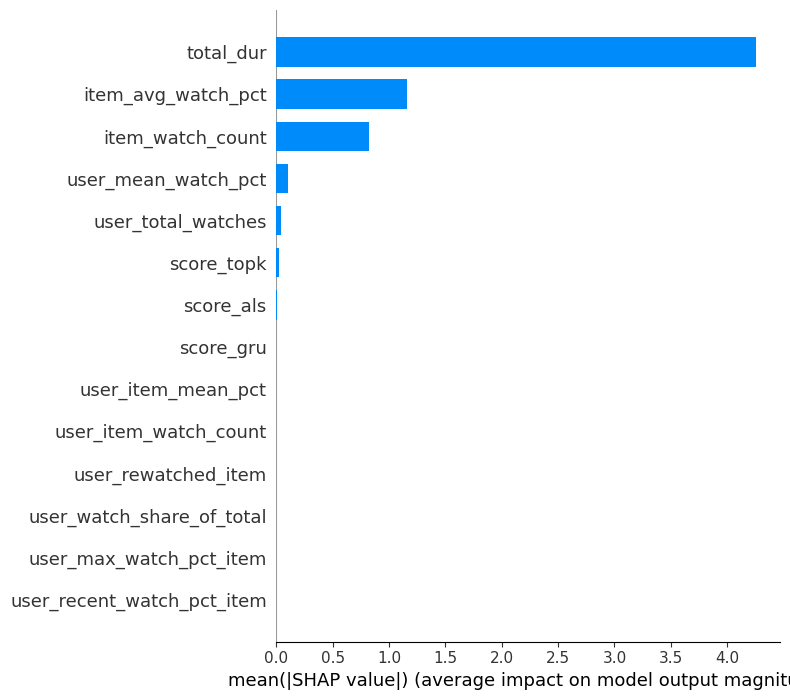

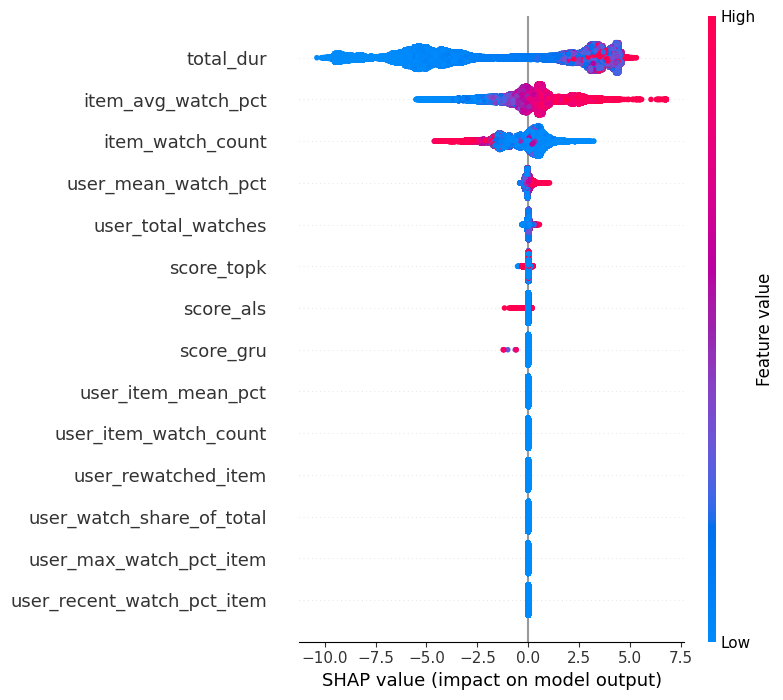

In [ ]:
import shap
import matplotlib.pyplot as plt

explainer = shap.TreeExplainer(model_xgb)
shap_values = explainer(X_sample)

shap.summary_plot(shap_values, X_sample, plot_type='bar')
shap.summary_plot(shap_values, X_sample)

Прикольно, что total_dur - время просмотра, роляет больше всего. Ну и наши сгенерированные фичи выбились в топ. А вот score от наших моделек не очень, но там и score этот есть далеко не у всех парь юзер-итем! Логично.


### 4 Этап. Инференс лучшего ранкера (max 3 балла)

Теперь мы хотим построить рекомендации "на завтра", для этого нам нужно:

1. Обучить модели первого уровня на всех (train+test) данных (0.5 балла)
2. Для каждой модели первого уровня для каждого пользователя сгененировать N кандидатов (0.5 балла)
3. "Склеить" всех кандидатов для каждого пользователя (дубли выкинуть), посчитать скоры от всех моделей (0.5 балла)
4. Собрать фичи для ваших кандидатов (теперь можем считать признаки на всех данных) (0.5 балла)
5. Проскорить всех кандидатов бустингом и оставить k лучших (0.5 балла)
6. Посчитать разнообразие(Diversity) и построить график от Diversity(k) (0.5 балла)


Все гиперпараметры (N, k) определяете только Вы!

In [ ]:
train_full = pd.concat([train_stage_1, valid_stage_1, test], ignore_index=True)

In [ ]:
train_full.shape

(5475423, 6)

In [ ]:
top_model_full = MyHeuristicModel()
top_model_full.fit(train_full)

top_wrapper_full = TopKHeuristic(top_model_full.popular_items)

In [ ]:
als_full = MyMatrixFactorization()
als_full.fit(train_full)
als_wrapper_full = ALSWrapper(als_full.model, als_full.user_map, als_full.item_map)

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
import gc
import torch

gc.collect()

if torch.cuda.is_available():
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()

In [ ]:
train_full_for_gru = train_full[['user_id', 'item_id', 'last_watch_dt']].copy()

train_full_for_gru['timestamp'] = pd.to_datetime(train_full_for_gru['last_watch_dt']).astype('int64') // 10**9
train_full_for_gru = train_full_for_gru.drop(columns='last_watch_dt')

save_path = 'data/gru4rec/train_full'
os.makedirs(save_path, exist_ok=True)

with open(os.path.join(save_path, 'train_full.inter'), 'w') as f:
    f.write('user_id:token\titem_id:token\ttimestamp:float\n')
    train_full_for_gru.to_csv(f, sep='\t', index=False, header=False)

In [ ]:
config_full = Config(
    model='GRU4Rec',
    dataset='train_full',
    config_dict={
        'data_path': 'data/gru4rec',
        'field_separator': '\t',
        'USER_ID_FIELD': 'user_id',
        'ITEM_ID_FIELD': 'item_id',
        'TIME_FIELD': 'timestamp',
        'load_col': {'inter': ['user_id', 'item_id', 'timestamp']},
        'MODEL_INPUT_TYPE': 'sequence',
        'MAX_ITEM_LIST_LENGTH': 50,
        'eval_args': {
            'split': {'RS': [0.8, 0.1, 0.1]},
            'order': 'TO',
            'mode': 'full',
            'group_by': 'user',
            'order_by': 'timestamp'
        },
        'metrics': ['Recall', 'NDCG'],
        'topk': [10],
        'valid_metric': 'Recall@10',
        'eval_batch_size': 8192,
        'train_epochs': 5,
        'train_batch_size': 4096,
        'loss_type': 'CE',
        'train_neg_sample_args': None,
        'device': 'cuda' if torch.cuda.is_available() else 'cpu',
        'train_num_workers': 2,
        'eval_num_workers': 1,
        'pin_memory': True,
        'prefetch': 4,
        'eval_step': 1,
        'stopping_step': 2,
        'show_progress': False
    }
)

In [ ]:
import torch
print("CUDA available:", torch.cuda.is_available())
print("Device:", config['device'])

CUDA available: True
Device: cuda


In [ ]:
init_seed(config_full['seed'], config_full['reproducibility'])
init_logger(config_full)

dataset_full = create_dataset(config_full)
train_data, valid_data, test_data = data_preparation(config_full, dataset_full)

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.




In [ ]:
train_data

In [ ]:
%%time

model_full = GRU4Rec(config_full, train_data.dataset).to(config_full['device'])
trainer_full = Trainer(config_full, model_full)

best_valid_score, best_valid_result = trainer_full.fit(train_data, valid_data, verbose=False, show_progress=False)

`torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.


CPU times: user 48min 50s, sys: 54.2 s, total: 49min 44s
Wall time: 40min 27s


In [ ]:
%%time

candidates_top_full = generate_candidates(top_wrapper_full, train_full['user_id'].unique(), 10, 'topk')
candidates_als_full = generate_candidates(als_wrapper_full, train_full['user_id'].unique(), 10, 'als')

CPU times: user 55min 43s, sys: 8.72 s, total: 55min 52s
Wall time: 28min 28s


In [ ]:
candidates_top_full.shape, candidates_als_full.shape

((9621510, 4), (9621510, 4))

In [ ]:
candidates_top_full.score.sum()

9621510.0

In [ ]:
candidates_top_full.head()

,user_id,item_id,score,model
0,310745,15297,1.0,topk
1,310745,10440,1.0,topk
2,310745,13865,1.0,topk
3,310745,9728,1.0,topk
4,310745,3734,1.0,topk


In [ ]:
candidates_als_full.head()

,user_id,item_id,score,model
0,310745,7571,0.006388,als
1,310745,12743,0.004687,als
2,310745,13018,0.004370,als
3,310745,12965,0.003693,als
4,310745,6774,0.003309,als


In [ ]:
internal_user_history_dict_full = get_internal_user_history_dict(dataset_full)

In [ ]:
model_full.eval()

GRU4Rec(
  (item_embedding): Embedding(15606, 64, padding_idx=0)
  (emb_dropout): Dropout(p=0.3, inplace=False)
  (gru_layers): GRU(64, 128, bias=False, batch_first=True)
  (dense): Linear(in_features=128, out_features=64, bias=True)
  (loss_fct): CrossEntropyLoss()
)

In [ ]:
gru_wrapper_full = GRU4RecWrapper(model_full, dataset_full, config_full)

In [ ]:
%%time

candidates_gru_full = generate_candidates_userwise(
    model=gru_wrapper_full,
    user2history=internal_user_history_dict_full,
    user_ids=list(internal_user_history_dict_full.keys()),
    k=10,
    model_name='gru'
)

Обработано 50000 из 606989 пользователей...
Обработано 100000 из 606989 пользователей...
Обработано 150000 из 606989 пользователей...
Обработано 200000 из 606989 пользователей...
Обработано 250000 из 606989 пользователей...
Обработано 300000 из 606989 пользователей...
Обработано 350000 из 606989 пользователей...
Обработано 400000 из 606989 пользователей...
Обработано 450000 из 606989 пользователей...
Обработано 500000 из 606989 пользователей...
Обработано 550000 из 606989 пользователей...
Обработано 600000 из 606989 пользователей...

Завершено. Всего: 606989
Обработано: 606989
Пропущено (пустые истории): 0
Пропущено (NaN/Inf): 0
Ошибки: 0
CPU times: user 6min 30s, sys: 2.65 s, total: 6min 33s
Wall time: 6min 33s


In [ ]:
candidates_gru_full.shape

(6069890, 4)

In [ ]:
candidates_gru_full.head()

,user_id,item_id,score,model
0,2,55,4.228240,gru
1,2,12,3.569906,gru
2,2,6,3.102523,gru
3,2,20,3.068337,gru
4,2,26,1.872598,gru


In [ ]:
df_l2_full = merge_model_outputs_for_l2(candidates_top_full, candidates_als_full, candidates_gru_full)

In [ ]:
df_l2_full.shape

(23781806, 5)

In [ ]:
df_l2_full.head()

,user_id,item_id,score_topk,score_als,score_gru
0,0,142,1.0,0.000000e+00,0.0
1,0,657,0.0,3.893564e-07,0.0
2,0,3734,1.0,0.000000e+00,0.0
3,0,4151,1.0,2.644804e-07,0.0
4,0,5803,0.0,3.072668e-07,0.0


In [ ]:
df_l2_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23781806 entries, 0 to 23781805
Data columns (total 5 columns):
 #   Column      Dtype  
---  ------      -----  
 0   user_id     int64  
 1   item_id     int64  
 2   score_topk  float64
 3   score_als   float64
 4   score_gru   float64
dtypes: float64(3), int64(2)
memory usage: 907.2 MB


In [ ]:
history_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5475423 entries, 0 to 5475422
Data columns (total 6 columns):
 #   Column         Dtype  
---  ------         -----  
 0   user_id        int64  
 1   item_id        int64  
 2   last_watch_dt  object 
 3   total_dur      int64  
 4   watched_pct    float64
 5   target         int64  
dtypes: float64(1), int64(4), object(1)
memory usage: 250.6+ MB


In [ ]:
history_full = pd.concat([train_stage_1, valid_stage_1, test], ignore_index=True)
history_full['last_watch_dt'] = pd.to_datetime(history_full['last_watch_dt'])

In [ ]:
history_full.shape

(5475423, 6)

In [ ]:
df_l2_full_all = history_full.merge(df_l2_full, on=['user_id', 'item_id'], how='left')

In [ ]:
df_l2_full_all.shape

(5475423, 9)

In [ ]:
df_l2_full_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5475423 entries, 0 to 5475422
Data columns (total 9 columns):
 #   Column         Dtype         
---  ------         -----         
 0   user_id        int64         
 1   item_id        int64         
 2   last_watch_dt  datetime64[ns]
 3   total_dur      int64         
 4   watched_pct    float64       
 5   target         int64         
 6   score_topk     float64       
 7   score_als      float64       
 8   score_gru      float64       
dtypes: datetime64[ns](1), float64(4), int64(4)
memory usage: 376.0 MB


In [ ]:
%%time

df_l2_full_feats = generate_features_by_day(df_l2_full_all, history_full)

100%|██████████| 163/163 [11:05<00:00,  4.08s/it]


CPU times: user 9min 28s, sys: 1min 42s, total: 11min 10s
Wall time: 11min 8s


In [ ]:
df_l2_full_feats = df_l2_full_feats.drop(columns=['watched_pct'])

In [ ]:
df_l2_full_feats.shape

(5475423, 18)

In [ ]:
df_l2_full_feats.head()

,user_id,item_id,last_watch_dt,total_dur,target,score_topk,score_als,score_gru,user_mean_watch_pct,user_total_watches,item_avg_watch_pct,item_watch_count,user_item_mean_pct,user_item_watch_count,user_max_watch_pct_item,user_recent_watch_pct_item,user_rewatched_item,user_watch_share_of_total
0,310745,13373,2021-03-13,4485,1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,952323,15997,2021-03-13,7507,1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,889459,11460,2021-03-13,60,0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,854016,11237,2021-03-13,5381,1,1.0,1.010682,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,307257,9132,2021-03-13,5814,1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
feature_cols = [col for col in df_l2_full_feats.columns if col not in ['user_id', 'item_id', 'last_watch_dt', 'target']]
X_final = df_l2_full_feats[feature_cols]
y_train = df_l2_full_feats['target']
X_final.shape

(5475423, 14)

In [ ]:
X_train.shape

(1456245, 14)

In [ ]:
df_l2_full_feats['ranker_score'] = model_xgb.predict_proba(X_final)[:, 1]

k = 10
topk_final = (
    df_l2_full_feats
    .sort_values(by=['user_id', 'ranker_score'], ascending=[True, False])
    .groupby('user_id')
    .head(k)
    .reset_index(drop=True)
)

In [ ]:
df_l2_full_feats.head()

,user_id,item_id,last_watch_dt,total_dur,target,score_topk,score_als,score_gru,user_mean_watch_pct,user_total_watches,item_avg_watch_pct,item_watch_count,user_item_mean_pct,user_item_watch_count,user_max_watch_pct_item,user_recent_watch_pct_item,user_rewatched_item,user_watch_share_of_total,ranker_score
0,310745,13373,2021-03-13,4485,1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.830061
1,952323,15997,2021-03-13,7507,1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.847814
2,889459,11460,2021-03-13,60,0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002912
3,854016,11237,2021-03-13,5381,1,1.0,1.010682,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.919657
4,307257,9132,2021-03-13,5814,1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.887922


In [ ]:
topk_final.shape

(3669171, 19)

In [ ]:
topk_final.head()

,user_id,item_id,last_watch_dt,total_dur,target,score_topk,score_als,score_gru,user_mean_watch_pct,user_total_watches,item_avg_watch_pct,item_watch_count,user_item_mean_pct,user_item_watch_count,user_max_watch_pct_item,user_recent_watch_pct_item,user_rewatched_item,user_watch_share_of_total,ranker_score
0,0,14359,2021-07-19,130,0,0.0,0.000000,0.0,0.0,1.0,56.379929,5909.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000223
1,0,7102,2021-07-19,169,0,0.0,0.000000,0.0,0.0,1.0,51.233581,10232.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000194
2,0,12192,2021-07-16,89,0,0.0,0.000000,0.0,0.0,0.0,4.806444,8938.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000166
3,0,15297,2021-07-19,459,0,1.0,0.000031,0.0,0.0,1.0,57.041289,130375.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000124
4,0,9728,2021-07-19,4,0,1.0,0.000000,0.0,0.0,1.0,65.340352,71905.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000046


In [ ]:
topk_lists = (
    topk_final
    .groupby('user_id')['item_id']
    .apply(list)
    .tolist()
)

unique_items = len(set(item for user_list in topk_lists for item in user_list))
num_users = len(topk_lists)
k = 10

diversity_k = unique_items / (k * num_users)
print(f"Diversity@{k}: {diversity_k:.4f}")

Diversity@10: 0.0013


Diversity@10 = 0.0013 — это крайне низкое разнообразие.  
Среди всех рекомендаций для всех пользователей очень мало разных айтемов.  
Это признак того, что модель рекомендует одно и то же всем (скорее всего, самые популярные айтемы).

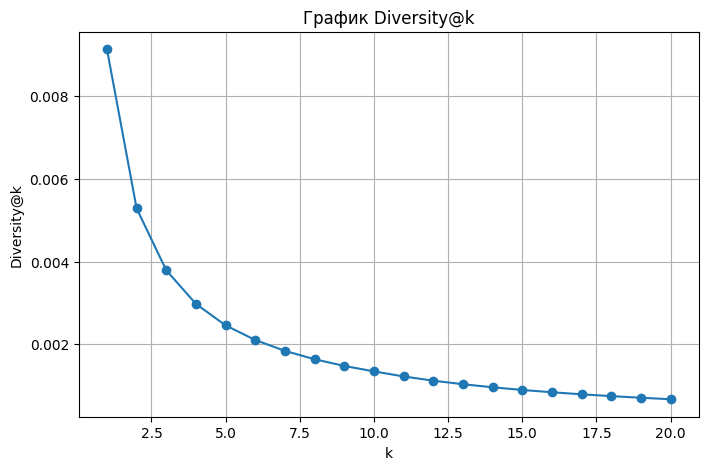

In [ ]:
from collections import defaultdict
import matplotlib.pyplot as plt

user2items = defaultdict(list)
for _, row in topk_final.iterrows():
    user2items[row['user_id']].append(row['item_id'])

diversity_scores = []
for k_val in range(1, 21):
    unique_items = set()
    for items in user2items.values():
        unique_items.update(items[:k_val])
    diversity = len(unique_items) / (k_val * len(user2items))
    diversity_scores.append(diversity)

plt.figure(figsize=(8, 5))
plt.plot(range(1, 21), diversity_scores, marker='o')
plt.xlabel("k")
plt.ylabel("Diversity@k")
plt.title("График Diversity@k")
plt.grid()
plt.show()

* У нас очень низкое разнообразие рекомендаций - например, при k=10 модель почти всем юзерам рекомендует одни и те же 10 айтемов.
* Это может быть признаком переобучения на популярные айтемы или сильного перекоса в сторону хита (hit bias).
* Модель не персонализирует выдачу: пользователи получают одинаковые рекомендации, особенно на больших k.